In [ ]:
Quantas retiradas de barra é bom
melhor seção

In [119]:
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
from fconcrete.helpers import cond
import copy

In [38]:
material = fc.Material(E='27000 MPa', poisson=1, alpha=1)
section = fc.Rectangle(25,44.6)

#Design
f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.SingleBeamElement([n1, n2], section, material)
bar2 = fc.SingleBeamElement([n2, n3], section, material)
bar3 = fc.SingleBeamElement([n3, n4], section, material)

fc.config.available_material = {
    "concrete_long_steel_bars":fc.AvailableLongConcreteSteelBar(diameters=[8]),
    "concrete_transv_steel_bars":fc.AvailableTransvConcreteSteelBar(diameters=[8]),
}
    
beam = fc.Beam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 2,
)

self1 = copy.deepcopy(beam)

entrou
entrou


In [24]:
beam._c1

80745.24861216143

0.00016180423077366267


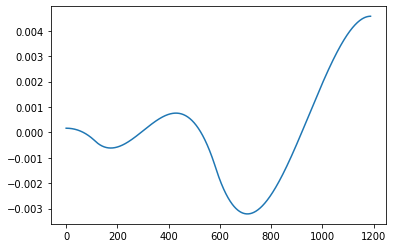

In [27]:
print(beam.getRotationDiagram()[1][0])
beam.plotRotationDiagram()

In [28]:
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
from fconcrete.helpers import cond


material = fc.Material(E='27000 MPa', poisson=1, alpha=1)
section = fc.Rectangle(25,44.6)

#Design
f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)

n1 = fc.Node.Crimp(x=0)
n2 = fc.Node.Free(x=113)

bar1 = fc.SingleBeamElement([n1, n2], section, material)

fc.config.available_material = {
    "concrete_long_steel_bars":fc.AvailableLongConcreteSteelBar(diameters=[8]),
    "concrete_transv_steel_bars":fc.AvailableTransvConcreteSteelBar(diameters=[8]),
}
    
beam = fc.Beam(
    loads = [f1],
    beam_elements = [bar1]
)

self2 = beam

entrou


In [30]:
beam._c1

-0.0

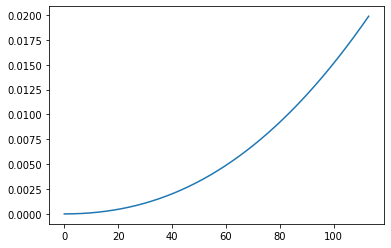

In [4]:
beam.plotDisplacementDiagram()

2.0751556478324717e-11


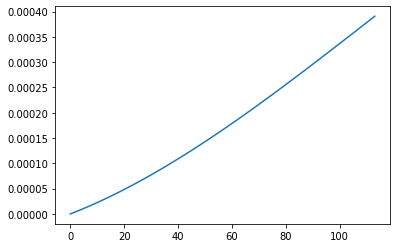

In [29]:
print(beam.getRotationDiagram()[1][0])
beam.plotRotationDiagram()

In [66]:
def getDisplacementParcial(self, x, c1=0, c2=0):
    if isinstance(x, int) or isinstance(x, float):
        
        if x < self.x_begin or x > self.x_end:
            return 0
        f_value = 0
        
        _, single_beam_element = self.getSingleBeamElementInX(x)
        for load in self.loads:
            f_value += load.momentum * \
                cond(x-load.x_begin, order=2)/2 if load.x_begin == load.x_end else 0
            f_value += load.force * \
                cond(x-load.x_begin, order=3)/6 if load.order == 0 else 0
            f_value += (load.q*cond(x-load.x_begin, order=load.order+3) -
                        load.q*cond(x-load.x_end, order=load.order+3))/((load.order+1)*(load.order+2)*(load.order+3))
        
        f_value += c1*x+c2
        return f_value
    elif isinstance(x, np.ndarray) or isinstance(x, list):
        return np.array([ getDisplacementParcial(self,x_element, c1, c2) for x_element in x ])

In [67]:
def getRotationParcial(self, x, c1=0):
    if isinstance(x, int) or isinstance(x, float):
        if x < self.x_begin or x > self.x_end:
            return 0
        f_value = 0
        
        _, single_beam_element = self.getSingleBeamElementInX(x)
        for load in self.loads:
            f_value += load.momentum * \
                cond(x-load.x_begin, order=1) if load.x_begin == load.x_end else 0
            f_value += load.force * \
                cond(x-load.x_begin, order=2)/2 if load.order == 0 else 0
            f_value += (load.q*cond(x-load.x_begin, order=load.order+2) -
                        load.q*cond(x-load.x_end, order=load.order+2))/((load.order+1)*(load.order+2))
        
        f_value += c1
        return f_value
    elif isinstance(x, np.ndarray) or isinstance(x, list):
        return np.array([ getDisplacementParcial(self,x_element, c1, c2) for x_element in x ])

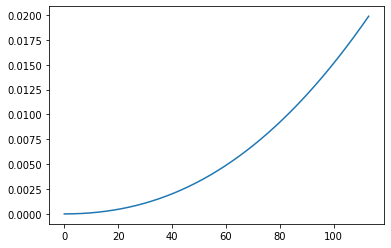

In [73]:
# Get constants of displacement function
self = self2

x, y = self.getMomentumDiagram()
null_displacement = self.nodes.x[self.nodes.condition_boundary[:, 1]==1]
null_rotation = self.nodes.x[self.nodes.condition_boundary[:, 0]==0]

x1 = null_displacement[0]

if len(null_displacement)>=2:
    rest1 = getDisplacementParcial(self, x1)
    x2 = null_displacement[-1]
    rest2 = getDisplacementParcial(self, x2)
    c1 = -(rest1 - rest2)/(x1-x2)
    c2 = rest1 + c1*x1
    
elif len(null_rotation)>=1 and len(null_displacement)>=1:
    x2 = null_rotation[0]
    c1 = -getRotationParcial(self, x2)
    rest1 = getDisplacementParcial(self, x2)
    c2 = rest1 + c1*x1
    
    
y_d = getDisplacementParcial(self, x, c1=c1, c2=c2)/self.bars[0].flexural_rigidity
plt.plot(x, y_d)


In [74]:
c1, c2

(-0.0, -0.0)

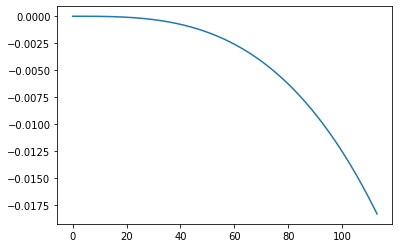

In [57]:
y_d = getDisplacementParcial(self, x, c1=-c1, c2=c2)/self.bars[0].flexural_rigidity
plt.plot(x, y_d)


In [8]:
a = abs(y_d.copy())
a.sort()

In [9]:
max(a)

0.7569819104511519

In [252]:
for null_displacement_u in null_displacement:
    print(np.interp(null_displacement_u, x, y_d))

7.195243205345225e-11
-6.672953907423019e-09
-1.860184507301079e-07
-2.031846166052598e-09


In [221]:
np.interp(583, x, y_d)

-2076.3167922731373

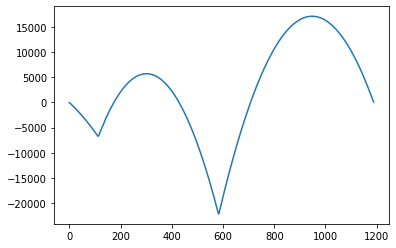

In [128]:
plt.plot(x, np.gradient(np.gradient(getDisplacementParcial(self, x, c1=c1, c2=c2))))

In [129]:
np.gradient(np.gradient(getDisplacementParcial(self, x, c1=c1, c2=c2)))[-1]

84.54928207397461

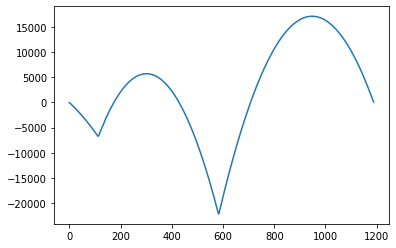

In [121]:
plt.plot(x, np.gradient(np.gradient(getDisplacement(self, x))))

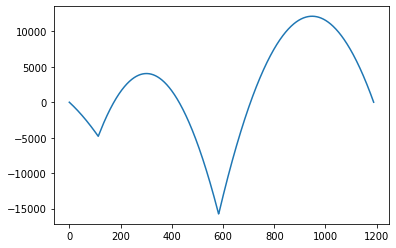

In [130]:
plt.plot(x, beam.getMomentumDiagram()[1])

In [132]:
x, y = beam.getMomentumDiagram()
np.trapz(x, y, dx=0.001, axis=1)

IndexError: list assignment index out of range

In [133]:
from scipy import integrate

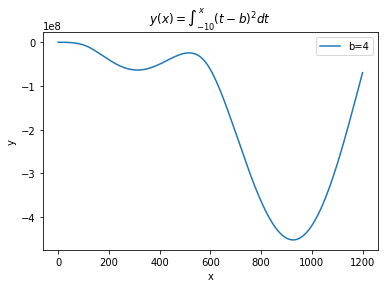

In [153]:
def integrals(f, xs):
    x_range = []
    y_range = []
    results = []
    for x in xs:
        x_range.append(x)
        y_range.append(f(x))
        integral = integrate.simps(y_range, x_range)
        results.append(integral)
    return results

def f(x):
    return beam.getInternalMomentumStrength(x)

xs = np.linspace(0, 1200, 1200)
vlinha = integrals(lambda x: f(x), xs)

def flinha(x):
    return np.interp(x, xs, vlinha)


displacement = integrals(lambda x: flinha(x), xs)
#plt.plot(xs, integrals(lambda x: f(x), xs), label='b=4')
plt.plot(xs, displacement, label='b=4')

plt.title('$y(x) = \int_{-10}^{x}(t-b)^2dt$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [148]:
np.interp(920.2, xs, np.array(displacement)/self.bars[0].flexural_rigidity)

-0.04028326431552984

In [155]:
integrate.RK23(f, 0, np.zeros(len(xs)), 1200)

TypeError: f() takes 1 positional argument but 2 were given

In [21]:
import sys
sys.path.insert(0, '../')
from fconcrete import config, duplicated, Material, Beam, Load, Node, ConcreteBeam, SingleBeamElement, Rectangle, Concrete, Section
e = config.e
from pytest import approx
import numpy as np
import os

import matplotlib.pyplot as plt

material = Material(E='27000 MPa', poisson=1, alpha=1)
section = Rectangle(25,44.6)

f1 = Load.PontualLoad(-5, x=29)
f2 = Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)

n1 = Node.Free(x=0)
n2 = Node.Crimp(x=113)

bar1 = SingleBeamElement([n1, n2], section, material)

beam = Beam(
    loads = [f1, f2],
    beam_elements = [bar1]
)
name="free_crimped"
'''

material = Material(E='27000 MPa', poisson=1, alpha=1)
section = Rectangle(25,44.6)

f1 = Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = Node.SimpleSupport(x=0)
n2 = Node.SimpleSupport(x=113)
n3 = Node.SimpleSupport(x=583)
n4 = Node.SimpleSupport(x=1188)

bar1 = SingleBeamElement([n1, n2], section, material)
bar2 = SingleBeamElement([n2, n3], section, material)
bar3 = SingleBeamElement([n3, n4], section, material)

beam = Beam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3]
)
    
name="v47"
'''


file_shear = r"../tests/structural/{}/shear.txt".format(name)
file_momentum = r"../tests/structural/{}/momentum.txt".format(name)
file_displacement = r"../tests/structural/{}/displacement.txt".format(name)

x_shear, shear_diagram_v47 = np.loadtxt(file_shear).T             
not_duplicated_x = ~duplicated(x_shear)
x_shear = x_shear[not_duplicated_x][1:-1]
shear_diagram_v47 = shear_diagram_v47[not_duplicated_x][1:-1]/100
shear_fconcrete = beam.getInternalShearStrength(x_shear)


x_momentum, momentum_diagram_v47 = np.loadtxt(file_momentum).T
not_duplicated_x = ~duplicated(x_momentum)
x_momentum = x_momentum[not_duplicated_x][1:-1]
momentum_diagram_v47 = momentum_diagram_v47[not_duplicated_x][1:-1]
momentum_fconcrete = beam.getInternalMomentumStrength(x_momentum)

x_displacement, _, displacement_diagram_v47, rotation_diagram_v47 = np.loadtxt(file_displacement).T
not_duplicated_x = ~duplicated(x_displacement)
x_displacement = x_displacement[not_duplicated_x]
displacement_diagram_v47 = displacement_diagram_v47[not_duplicated_x]
displacement_fconcrete = beam.getDisplacement(x_displacement)*10

rotation_diagram_v47 = rotation_diagram_v47[not_duplicated_x]
rotation_fconcrete = beam.getRotation(x_displacement)

#return (shear_diagram_v47, shear_fconcrete), (momentum_diagram_v47, momentum_fconcrete), (displacement_diagram_v47, displacement_fconcrete), (rotation_diagram_v47, rotation_fconcrete) 
    


[0.]
[0.]
entrou
-0.0


In [27]:
assert rotation_diagram_v47 == approx(rotation_fconcrete, abs=0.0000001)
assert displacement_diagram_v47 == approx(displacement_fconcrete, abs=0.000001)


AssertionError: 

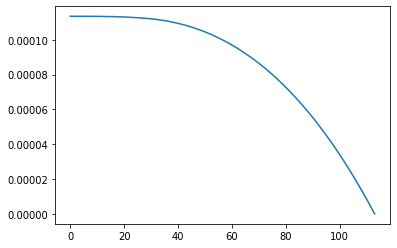

In [28]:
plt.plot(x_displacement, rotation_diagram_v47)

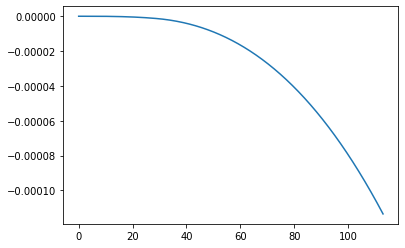

In [29]:
plt.plot(x_displacement, rotation_fconcrete)

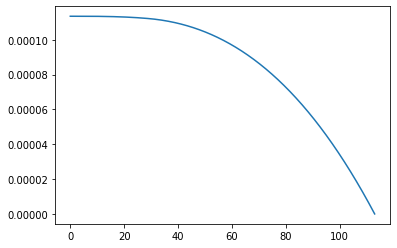

In [2]:
plt.plot(x_displacement, rotation_fconcrete)

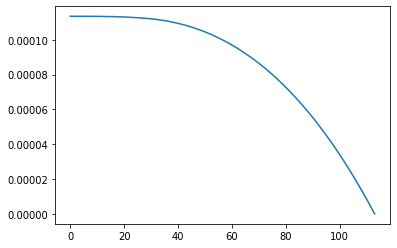

In [3]:
plt.plot(x_displacement, rotation_diagram_v47)

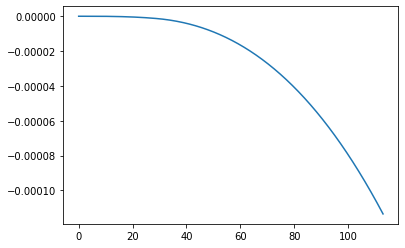

In [13]:
plt.plot(x_displacement, rotation_fconcrete)

In [82]:
assert shear_diagram_v47 == approx(shear_diagram_v47, abs=1)

In [102]:
for x, ft, fc in zip(x_displacement, momentum_diagram_v47, momentum_fconcrete):
    
    if ft != approx(fc, abs=0.00001):
        print(x, ft, fc)

0.0 -21.451473 -20.04464051357056
0.6 -42.969809 -43.50385544606946
1.3 -64.555007 -63.67501195963993
1.9 -86.207068 -87.28182889213883
2.6 -107.925991 -107.57950140570931
3.2 -129.711776 -131.33392033820817
3.9 -151.564424 -151.75810885177867
4.5 -173.483935 -172.24068936534914
5.1 -195.470308 -196.21083429784804
5.8 -217.523543 -216.81993081141852
6.4 -239.643641 -240.9376777439174
7.1 -261.830601 -261.67329025748785
7.7 -284.084424 -282.4672947710584
8.3 -306.405109 -306.80076770355726
9.0 -328.792657 -327.7212882171277
9.6 -351.247067 -352.20236314962665
10.3 -373.76834 -373.2493996631971
10.9 -396.356475 -397.878076595696
11.6 -419.011472 -419.05162910926646
12.2 -441.733333 -440.28357362283697
12.8 -464.522055 -465.1279765553358
13.5 -487.37764 -486.4864370689063
14.1 -510.300088 -511.47844200140526
14.8 -533.289398 -532.9634185149756
15.4 -556.34557 -558.1030254474747
16.1 -579.468605 -579.7145179610451
16.7 -602.658502 -601.3844024746156
17.3 -625.915262 -626.7397354071144
18.0

958.3 12081.285328 12081.31787358172
960.8 12065.850684 12065.578163662212
963.4 12047.681718 12047.76887720116
965.9 12026.778432 12026.465271281646
968.5 12003.140824 12003.306084820593
971.0 11976.768895 11976.438582901086
973.6 11947.662644 11947.929496439989
976.1 11915.822073 11915.498098520475
978.7 11881.24718 11881.63911205942
981.2 11843.937965 11843.643818139928
983.8 11803.89443 11804.434931678887
986.3 11761.116573 11760.87574175933
988.9 11715.604396 11716.316955298287
991.4 11667.357896 11667.193869378782
994.0 11616.377076 11617.285182917694
996.5 11562.661934 11562.598200998196
999.1 11506.212472 11507.339614537137
1001.6 11447.028687 11447.088736617618
1004.2 11385.110582 11384.001362698124
1006.8 11320.458155 11320.665476237045
1009.3 11253.071408 11252.014206317515
1011.9 11182.950339 11183.32841985645
1014.4 11110.094948 11109.113253936986
1017.0 11034.505237 11035.077567475892
1019.5 10956.181204 10955.298505556348
1022.1 10875.12285 10875.91291909531
1024.6 10791

In [129]:
beam.getInternalMomentumStrength(0.642045)

-21.451457974381242

In [ ]:
0.642045	-21.451473